In [5]:
import pytrends
import statsmodels
from pytrends.request import TrendReq
import pandas as pd
import numpy as np
import datetime as dt
import time
from longtrends import rescale_overlaps, rescaled_longtrend
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
import time

### Read and process data by authors

In [85]:
all_movies = pd.read_excel('sample_of_312.xlsx')

In [86]:
all_movies

,ID,Title,WP_page_title,First_weekend_revenue_USD,Number_of theaters,Date_of_release,Inception_of_article_(movie_time_days)
0,1,127 Hours,127_Hours,264851,4,2010-05-11 00:00:00,340
1,2,2012 Time for Change,2012:_Time_for_Change,9009,1,2010-09-04 00:00:00,29
2,3,44 Inch Chest,44_Inch_Chest,4185,1,01/15/2010,510
3,4,45365,45365,107,1,02/26/2010,-9
4,5,71 Into the Fire,71:_Into_the_Fire,77161,20,07/30/2010,62
...,...,...,...,...,...,...,...
307,308,Winter's Bone,Winter%27s_Bone,84797,4,2010-11-06 00:00:00,131
308,309,Yogi Bear,Yogi_Bear_(film),16411322,3515,12/17/2010,778
309,310,You Again,You_Again,8407513,2548,09/24/2010,176
310,311,You Will Meet a Tall Dark Stranger,You_Will_Meet_a_Tall_Dark_Stranger,160103,6,09/22/2010,330


In [87]:
def format_date(date_example):
    if type(date_example) == str:
        input_date = dt.datetime.strptime(date_example, '%m/%d/%Y')
        output_date = dt.datetime(input_date.year, input_date.month, input_date.day)
    else:
        output_date = dt.datetime(date_example.year, date_example.day, date_example.month)
    return output_date.date()

In [88]:
all_movies['Date_of_release'] = all_movies['Date_of_release'].apply(format_date)

In [89]:
all_movies['Title'] = all_movies['Title'].astype(str)

In [417]:
all_movies

,ID,Title,WP_page_title,First_weekend_revenue_USD,Number_of theaters,Date_of_release,Inception_of_article_(movie_time_days)
0,1,127 Hours,127_Hours,264851,4,2010-11-05,340
1,2,2012 Time for Change,2012:_Time_for_Change,9009,1,2010-04-09,29
2,3,44 Inch Chest,44_Inch_Chest,4185,1,2010-01-15,510
3,4,45365,45365,107,1,2010-02-26,-9
4,5,71 Into the Fire,71:_Into_the_Fire,77161,20,2010-07-30,62
...,...,...,...,...,...,...,...
307,308,Winter's Bone,Winter%27s_Bone,84797,4,2010-06-11,131
308,309,Yogi Bear,Yogi_Bear_(film),16411322,3515,2010-12-17,778
309,310,You Again,You_Again,8407513,2548,2010-09-24,176
310,311,You Will Meet a Tall Dark Stranger,You_Will_Meet_a_Tall_Dark_Stranger,160103,6,2010-09-22,330


In [90]:
movie_names = all_movies['Title'].tolist()

### Retrieve the dates of the start and end of the needed time interval

In [84]:
all_movies['Date_of_release'].tolist().index(max(all_movies['Date_of_release'].tolist()))

17

In [85]:
all_movies.iloc[[17]]

,ID,Title,WP_page_title,First_weekend_revenue_USD,Number_of theaters,Date_of_release,Inception_of_article_(movie_time_days)
17,18,Another Year,Another_Year_(film),111869,6,2010-12-29,285


In [9]:
all_movies['Date_of_release'].tolist().index(min(all_movies['Date_of_release'].tolist()))

23

In [10]:
all_movies.iloc[[23]]

,ID,Title,WP_page_title,First_weekend_revenue_USD,Number_of theaters,Date_of_release,Inception_of_article_(movie_time_days)
23,24,Bitch Slap,Bitch_Slap,12254,3,2010-01-08,534


### Prepare data requesting

In [100]:
movies = TrendReq(retries=3) 

In [101]:
def check_trend(trend_list):
    # function to combine the trend data from different intervals
    print(len(trend_list))
    if len(trend_list) <= 1:
        whole = fourth_part.append([third_part, second_part, first_part])
        return whole[~whole.index.duplicated(keep='first')].sort_index()

    else:
        if 0 in trend_list[-1].value_counts().index and (trend_list[-1].value_counts()[0] > 260 or len(trend_list[-1].value_counts()) <= 2):
            return check_trend(trend_list[:-1])
        
        elif 0 in trend_list[0].value_counts().index and (trend_list[0].value_counts()[0] > 260 or len(trend_list[0].value_counts()) <= 2):
            return check_trend(trend_list[1:])
        else:
           new_value = 100
           
           new_index = trend_list[-1].index[0] - dt.timedelta(days=1)
          # print(new_index)
           trend_list[-1].loc[new_index] = new_value
           trend_list[-1].sort_index(inplace=True)
          # print(trend_list[-1])
           return rescaled_longtrend(rescale_overlaps(trend_list))

### Retrieve first batch of movies

In [332]:
first = []
second = []
third = []
fourth = []
trends = dict()
for index, movie in enumerate(movie_names):
    print(movie)
    movies.build_payload([movie, 'wikipedia'], cat=0, timeframe=f'2008-12-04 2009-08-30', geo='US', gprop='')
    first_part = movies.interest_over_time()[movie]

    movies.build_payload([movie, 'wikipedia'], cat=0, timeframe=f'2009-06-17 2010-03-13', geo='US', gprop='')
    second_part = movies.interest_over_time()[movie]

    movies.build_payload([movie, 'wikipedia'], cat=0, timeframe=f'2009-12-29 2010-09-24', geo='US', gprop='')
    third_part = movies.interest_over_time()[movie]

    movies.build_payload([movie, 'wikipedia'], cat=0, timeframe=f'2010-07-13 2011-04-08', geo='US', gprop='')
    fourth_part = movies.interest_over_time()[movie]
    
    first.append(first_part)
    second.append(second_part)
    third.append(third_part)
    fourth.append(fourth_part)
    
    trends[movie] = check_trend([fourth_part, third_part, second_part, first_part])
    time.sleep(10)

127 Hours
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


2012 Time for Change
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


44 Inch Chest
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


45365
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


71 Into the Fire
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


8 The Mormon Proposition
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


A Film Unfinished
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


After.Life
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Aftershock
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Alice in Wonderland
4
All About Evil
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


All Good Things
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Alpha and Omega
4
3
2
And Everything Is Going Fine
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


A Nightmare on Elm Street
4
3
2
Animal Kingdom
4
Anjaana Anjaani
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Another Year
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


A Prophet
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Babies
4
Band Baaja Baaraat
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Behind the Burly Q
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Best Worst Movie
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Bitch Slap
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Black Swan
4
3
2
Blue Valentine
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


BoyBand
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Bran Nue Dae
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Breath Made Visible
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Brooklyn's Finest
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Brotherhood
4
Buried
4
Burlesque
4
3
2
Cairo Time
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Carbon Nation
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Case 39
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Casino Jack and the United States of Money
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Casino Jack
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Catfish
4
Cats and Dogs The Revenge of Kitty Galore
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Centurion
4
3
2
Chain Letter
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Chance Pe Dance
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Charlie St. Cloud
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Children of Invention
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Clash of the Titans
4
3
Client 9 The Rise and Fall of Eliot Spitzer
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Come Undone
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Cool It
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Cop Out
4
3
Countdown to Zero
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Country Strong
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Crazy on the Outside
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Dabangg
4
3
2
Date Night
4
3
2
Daybreakers
4
3
2
Dear John
4
3
Death at a Funeral
4
3
2
Defendor
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Despicable Me
4
3
2
Devil
4
Diary of a Wimpy Kid
4
3
Dinner for Schmucks
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Douchebag
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Down Terrace
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Dreamkiller
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Due Date
4
Eat Pray Love
4
3
2
Edge of Darkness
4
3
Enter the Void
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Everyone Else
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Exit Through the Gift Shop
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Extraordinary Measures
4
3
2
Fair Game
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Faster
4
Finding Bliss
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Flipped
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


For Colored Girls
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Formosa Betrayed
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Four Lions
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Freakonomics
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


From Paris with Love
4
3
2
Frozen
4
Furry Vengeance
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Gasland
4
3
2
Get Him to the Greek
4
3
2
Going the Distance
4
3
2
Golmaal 3
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Great Directors
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Greenberg
4
Green Zone
4
3
Grown Ups
4
3
2
Gulliver%27s Travels
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Guy and Madeline on a Park Bench
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Guzaarish
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Handsome Harry
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Happy Tears
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Heartbreaker
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Helena from the Wedding
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Henri-Georges Clouzot%27s Inferno
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Hereafter
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Holy Rollers
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Hot Tub Time Machine
4
3
Housefull
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


How Do You Know
4
Howl
4
3
How to Train Your Dragon
4
3
Hugh Hefner Playboy Activist and Rebel
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


I'm Still Here
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


I Hate Luv Storys
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Inception
4
Inhale
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


In My Sleep
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Inside Job
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Iron Man 2
4
I Spit on Your Grave
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


It's Kind of a Funny Story
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


I Want Your Money
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Jackass 3D
4
3
2
Jack Goes Boating
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Jean-Michel Basquiat The Radiant Child
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Joan Rivers A Piece of Work
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Jonah Hex
4
Just Wright
4
3
2
Karthik Calling Karthik
4
3
2
Khatta Meetha
4
3
2
Kick-Ass
4
3
2
Killers
4
Kites
4
3
2
Kites The Remix
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Knight and Day
4
3
2
La Soga
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Leap Year
4
Legendary
4
Legend of the Guardians The Owls of Ga%27Hoole
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Legion
4
Let Me In
4
3
2
Letters to God
4
3
2
Letters to Juliet
4
3
2
Life as We Know It
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Like Dandelion Dust
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Little Fockers
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Logan
4
Looking for Eric


RetryError: HTTPSConnectionPool(host='trends.google.com', port=443): Max retries exceeded with url: /trends/api/explore?hl=en-US&tz=360&req=%7B%22comparisonItem%22%3A+%5B%7B%22keyword%22%3A+%22Looking+for+Eric%22%2C+%22time%22%3A+%222008-12-04+2009-08-30%22%2C+%22geo%22%3A+%22US%22%7D%2C+%7B%22keyword%22%3A+%22wikipedia%22%2C+%22time%22%3A+%222008-12-04+2009-08-30%22%2C+%22geo%22%3A+%22US%22%7D%5D%2C+%22category%22%3A+0%2C+%22property%22%3A+%22%22%7D (Caused by ResponseError('too many 429 error responses'))

### Retrieve second batch of movies (due to exceeded API Quota)

In [725]:
movie_names.index('Logan')
movie_names2 = movie_names[145:]
movie_names2.append('Conviction')

In [726]:
first2 = []
second2 = []
third2 = []
fourth2 = []
trends2 = dict()
for index, movie in enumerate(movie_names2):
    print(movie)
    movies.build_payload([movie, 'wikipedia'], cat=0, timeframe=f'2008-12-04 2009-08-30', geo='US', gprop='')
    first_part = movies.interest_over_time()[movie]

    movies.build_payload([movie, 'wikipedia'], cat=0, timeframe=f'2009-06-17 2010-03-13', geo='US', gprop='')
    second_part = movies.interest_over_time()[movie]

    movies.build_payload([movie, 'wikipedia'], cat=0, timeframe=f'2009-12-29 2010-09-24', geo='US', gprop='')
    third_part = movies.interest_over_time()[movie]

    movies.build_payload([movie, 'wikipedia'], cat=0, timeframe=f'2010-07-13 2011-04-08', geo='US', gprop='')
    fourth_part = movies.interest_over_time()[movie]
    
    first2.append(first_part)
    second2.append(second_part)
    third2.append(third_part)
    fourth2.append(fourth_part)
    
    trends2[movie] = check_trend([fourth_part, third_part, second_part, first_part])
    time.sleep(10)

Looking for Eric
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Lottery Ticket
4
3
2
Love and Other Drugs
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Love Ranch
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


MacGruber
4
3
Machete
4
3
2
Made in Dagenham
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Mademoiselle Chambon
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Marmaduke
4
3
2
Marwencol
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Megamind
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Monsters
4
Morning Glory
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Mugabe and the White African
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Multiple Sarcasms
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


My Dog Tulip
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


My Name Is Khan
4
3
2
My Soul to Take
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Never Let Me Go
4
3
2
Night Catches Us
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


No One Knows About Persian Cats
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


No Problem
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Nowhere Boy
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Ondine
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Only When I Dance
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


OSS 117 Lost in Rio
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Our Family Wedding
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Paranormal Activity 2
4
3
2
Peepli Live
4
3
2
Percy Jackson and the Olympians The Lightning Thief
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Perrier's Bounty
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Piranha 3D
4
3
2
Please Give
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Preacher's Kid
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Predators
4
Prince of Persia The Sands of Time
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Raajneeti
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Raavan
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Rabbit Hole
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Racing Dreams
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Ramona and Beezus
4
3
2
Rare Exports A Christmas Tale
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Red Hill
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


RED
4
Remember Me
4
Repo Men
4
3
2
Resident Evil Afterlife
4
3
2
Restrepo
4
3
2
Robin Hood
4
Saint John of Las Vegas
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Salt
4
Saw 3D
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Scott Pilgrim vs. the World
4
3
2
Secretariat
4
3
2
See What I%27m Saying The Deaf Entertainers Documentary
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Sex and the City 2
4
3
She's Out of My League
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Shrek Forever After
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Shutter Island
4
Skyline
4
Smash His Camera
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Somewhere
4
Speed-Dating
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Standing Ovation
4
3
Step Up 3D
4
3
2
Stone
4
Stonewall Uprising
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Summer Wars
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Takers
4
3
2
Tamara Drewe
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Tangled
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Tees Maar Khan
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


The American
4
The A-Team
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


The Back-up Plan
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


The Black Waters of Echo%27s Pond
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


The Book of Eli
4
3
The Bounty Hunter
4
The Cartel
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


The Chronicles of Narnia The Voyage of the Dawn Treader
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


The City of Your Final Destination
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


The Crazies
4
3
The Disappearance of Alice Creed
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


The Dry Land
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


The Expendables
4
3
The Extra Man
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


The Fighter
4
The Girl on the Train
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


The Good Heart
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


The Harimaya Bridge
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


The Illusionist
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


The Joneses
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


The Karate Kid
4
3
2
The Kids Are All Right
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


The Killer Inside Me
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


The King's Speech
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


The Last Airbender
4
The Last Exorcism
4
3
2
The Last Song
4
The Last Station
4
3
2
The Legend of Pale Male
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


The Losers
4
3
2
The Lottery
4
The Man from Nowhere
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


The Milk of Sorrow
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


The Most Dangerous Man in America Daniel Ellsberg and the Pentagon Papers
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


The Next Three Days
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


The Nutcracker in 3D
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


The Oath
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


The Other Guys
4
3
2
The People I've Slept With
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


The Perfect Game
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


The Red Chapel
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


The Romantics
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


The Runaways
4
The Secret in Their Eyes
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


The Secret of Kells
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


The Social Network
4
3
2
The Sorcerer's Apprentice
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


The Spy Next Door
4
3
2
The Strange Case of Angelica
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


The Switch
4


ValueError: unable to scale: to_scale has range 0 in overlap with scale_by; this may be because of an extreme spike in trend data

In [829]:
movie_names.index('The Town') # 145, 267, 269, 274, 275
movie_names3 = movie_names[275:]

In [ ]:
trends2 = dict()

In [830]:
for index, movie in enumerate(movie_names3):
    print(movie)
    movies.build_payload([movie, 'wikipedia'], cat=0, timeframe=f'2008-12-04 2009-08-30', geo='US', gprop='')
    first_part = movies.interest_over_time()[movie]

    movies.build_payload([movie, 'wikipedia'], cat=0, timeframe=f'2009-06-17 2010-03-13', geo='US', gprop='')
    second_part = movies.interest_over_time()[movie]

    movies.build_payload([movie, 'wikipedia'], cat=0, timeframe=f'2009-12-29 2010-09-24', geo='US', gprop='')
    third_part = movies.interest_over_time()[movie]

    movies.build_payload([movie, 'wikipedia'], cat=0, timeframe=f'2010-07-13 2011-04-08', geo='US', gprop='')
    fourth_part = movies.interest_over_time()[movie]
    
    first2.append(first_part)
    second2.append(second_part)
    third2.append(third_part)
    fourth2.append(fourth_part)
    
    trends2[movie] = check_trend([fourth_part, third_part, second_part, first_part])
    time.sleep(10)

The Twilight Saga Eclipse
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


The Virginity Hit
4
3
2
The Warrior's Way
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


The Weathered Underground
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


The Wildest Dream
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


The Wolfman
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Tiny Furniture
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Tooth Fairy
4
3
2
To Save a Life
4
3
Toy Story 3
4
Tron Legacy
4
True Grit
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Twelve
4
3
Two in the Wave
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Udaan
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Unstoppable
4
Valentine's Day
4
Vampires Suck
4
3
2
Veer
4
3
Vincere
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Waiting for Armageddon
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Waking Sleeping Beauty
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Wall Street Money Never Sleeps
4
3
2
Waste Land
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


We Are Family
4
3
2
Welcome to the Rileys
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


What If...
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


When in Rome
4
3
When You're Strange
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


White Material
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Wild Grass
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Winnebago Man
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Winter's Bone
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Yogi Bear
4
3
2
You Again
4
You Will Meet a Tall Dark Stranger
4
3
2
1


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\1123059440.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole = fourth_part.append([third_part, second_part, first_part])


Zenith
4


ValueError: unable to scale: to_scale has range 0 in overlap with scale_by; this may be because of an extreme spike in trend data

In [803]:
first2 = []
second2 = []
third2 = []
fourth2 = []
for index, movie in enumerate(['Conviction']):
    print(movie)
    movies.build_payload([movie, 'wikipedia'], cat=0, timeframe=f'2008-12-04 2009-08-30', geo='US', gprop='')
    first_part = movies.interest_over_time()[movie]

    movies.build_payload([movie, 'wikipedia'], cat=0, timeframe=f'2009-06-17 2010-03-13', geo='US', gprop='')
    second_part = movies.interest_over_time()[movie]

    movies.build_payload([movie, 'wikipedia'], cat=0, timeframe=f'2009-12-29 2010-09-24', geo='US', gprop='')
    third_part = movies.interest_over_time()[movie]

    movies.build_payload([movie, 'wikipedia'], cat=0, timeframe=f'2010-07-13 2011-04-08', geo='US', gprop='')
    fourth_part = movies.interest_over_time()[movie]
    
    first2.append(first_part)
    second2.append(second_part)
    third2.append(third_part)
    fourth2.append(fourth_part)
    
    trends2[movie] = check_trend([fourth_part, third_part, second_part, first_part])
    time.sleep(10)

Conviction
4


ValueError: unable to scale: to_scale has range 0 in overlap with scale_by; this may be because of an extreme spike in trend data

In [814]:
the_switch = check_trend([fourth_part, third_part])
trends2['The Switch'] = the_switch

2


In [824]:
the_town = check_trend([fourth_part, third_part])
trends2['The Town'] = the_town

2


In [806]:
conviction = fourth_part.append([third_part, second_part, first_part])
conviction.sort_index(inplace=True)
conviction.index.drop_duplicates()
trends2['Conviction'] = conviction

C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3845053253.py:1: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  conviction = fourth_part.append([third_part, second_part, first_part])


In [828]:
the_trial = fourth_part.append([third_part, second_part, first_part])
the_trial.sort_index(inplace=True)
the_trial.index.drop_duplicates()
trends2['The Trial'] = the_trial

C:\Users\HP\AppData\Local\Temp\ipykernel_16836\723296596.py:1: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  the_trial = fourth_part.append([third_part, second_part, first_part])


In [831]:
zenith = fourth_part.append([third_part, second_part, first_part])
zenith.sort_index(inplace=True)
zenith.index.drop_duplicates()
trends2['Zenith'] = zenith

C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3406823101.py:1: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  zenith = fourth_part.append([third_part, second_part, first_part])


In [821]:
the_tempest = fourth_part.append([third_part, second_part, first_part])
the_tempest.sort_index(inplace=True)
the_tempest.index.drop_duplicates()
trends2['The Tempest'] = the_tempest

C:\Users\HP\AppData\Local\Temp\ipykernel_16836\897125752.py:1: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  the_tempest = fourth_part.append([third_part, second_part, first_part])


In [102]:
first = []
second = []
third = []
fourth = []
trends3 = dict()
for index, movie in enumerate(['Easy A']):
    print(movie)
    movies.build_payload([movie, 'wikipedia'], cat=0, timeframe=f'2008-12-04 2009-08-30', geo='US', gprop='')
    first_part = movies.interest_over_time()[movie]

    movies.build_payload([movie, 'wikipedia'], cat=0, timeframe=f'2009-06-17 2010-03-13', geo='US', gprop='')
    second_part = movies.interest_over_time()[movie]

    movies.build_payload([movie, 'wikipedia'], cat=0, timeframe=f'2009-12-29 2010-09-24', geo='US', gprop='')
    third_part = movies.interest_over_time()[movie]

    movies.build_payload([movie, 'wikipedia'], cat=0, timeframe=f'2010-07-13 2011-04-08', geo='US', gprop='')
    fourth_part = movies.interest_over_time()[movie]
    
    first.append(first_part)
    second.append(second_part)
    third.append(third_part)
    fourth.append(fourth_part)
    
    trends3[movie] = check_trend([fourth_part, third_part, second_part, first_part])
    time.sleep(10)

Easy A
4


### Create example plots for the rescaling process

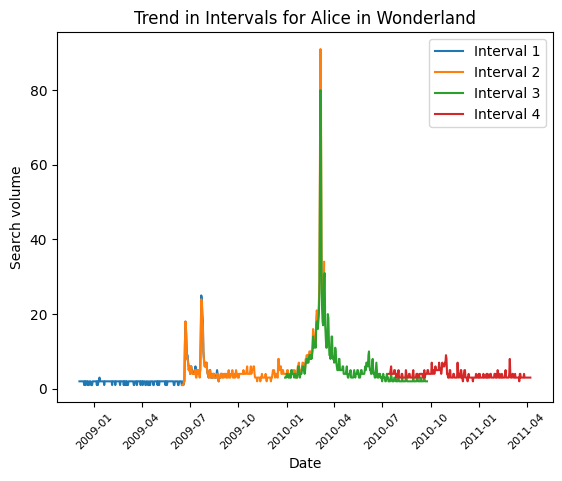

In [362]:
#trends['Alice in Wonderland'].plot()

plt.plot(first[9][1:], label='Interval 1')
plt.plot(second[9], label='Interval 2')
plt.plot(third[9], label='Interval 3')
plt.plot(fourth[9], label='Interval 4')

# Adding a legend
plt.legend()
plt.xlabel('Date')
plt.ylabel('Search volume')

# Adding a title
plt.title('Trend in Intervals for Alice in Wonderland')

# Customizing x-axis ticks
plt.xticks(rotation=45)  # Rotate the tick labels by 45 degrees
plt.tick_params(axis='x', labelsize=8)  # Adjust the font size of x-axis tick labels
plt.savefig('trend_interval.png')

# Show the plot
plt.show()

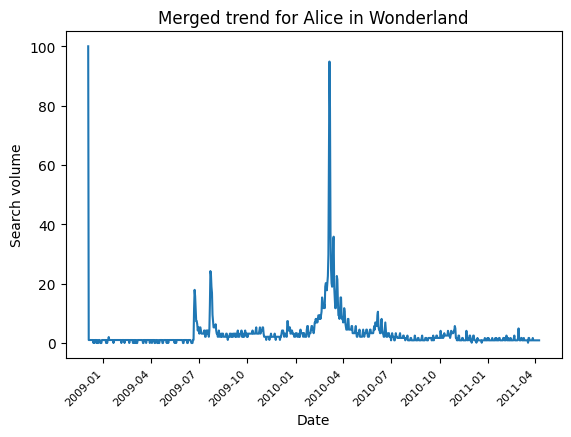

In [363]:
trends['Alice in Wonderland'][:-1].plot()

# Adding a legend
#plt.legend()
plt.xlabel('Date')
plt.ylabel('Search volume')

# Adding a title
plt.title('Merged trend for Alice in Wonderland')

# Customizing x-axis ticks
plt.xticks(rotation=45)  # Rotate the tick labels by 45 degrees
plt.tick_params(axis='x', labelsize=8)  # Adjust the font size of x-axis tick labels
plt.savefig('trend_merged.png')
# Show the plot
plt.show()

### Process and combine the data to one data frame 

In [654]:
trends_processed = {}
count = 0
for movie in trends.keys():
    print(movie)
    index = all_movies.index[all_movies['Title'] == movie]
    #print(index)
    release = all_movies[all_movies['Title'] == movie]['Date_of_release'][index]
    start = release - dt.timedelta(days= 400)
    end = release + dt.timedelta(days= 100)
    start = start[index[0]]
    end = end[index[0]]
    trends[movie][0] = 0
    
    if start not in trends[movie].index:
        count =+ 1
        trends[movie].sort_index(inplace = True)

    # Append the new_date and fill values with 0 for all dates in between
        trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
        trends_processed[movie] = trends_processed[movie][~trends_processed[movie].index.duplicated(keep='first')]
        trends_processed[movie].sort_index(inplace = True)
        trends_processed[movie] = trends_processed[movie][start:end].to_frame()

    else:
        trends_processed[movie] = trends[movie][start:end].to_frame()
    trends_processed[movie]['index'] = range(-400,101)

# Set the 'New_Column' as the index of the DataFrame
    trends_processed[movie].set_index('index', inplace=True)

127 Hours
2012 Time for Change


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a fut

44 Inch Chest
45365
71 Into the Fire
8 The Mormon Proposition


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a fut

A Film Unfinished
After.Life


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a futur

Aftershock
Alice in Wonderland


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a fut

All About Evil
All Good Things


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a futur

Alpha and Omega
And Everything Is Going Fine
A Nightmare on Elm Street
Animal Kingdom


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a futur

Anjaana Anjaani
Another Year
A Prophet
Babies


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a fut

Band Baaja Baaraat
Behind the Burly Q
Best Worst Movie
Bitch Slap


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a futur

Black Swan
Blue Valentine
BoyBand
Bran Nue Dae


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a fut

Breath Made Visible
Brooklyn's Finest
Brotherhood
Buried


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a futur

Burlesque
Cairo Time
Carbon Nation
Case 39


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a fut

Casino Jack and the United States of Money


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))


Casino Jack
Catfish


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a fut

Cats and Dogs The Revenge of Kitty Galore
Centurion
Chain Letter


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a fut

Chance Pe Dance
Charlie St. Cloud


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a fut

Children of Invention
Clash of the Titans


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a futur

Client 9 The Rise and Fall of Eliot Spitzer
Come Undone


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a futur

Cool It
Cop Out
Countdown to Zero


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a futur

Country Strong
Crazy on the Outside
Dabangg
Date Night


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

Daybreakers
Dear John
Death at a Funeral
Defendor


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtyp

Despicable Me
Devil
Diary of a Wimpy Kid
Dinner for Schmucks


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a fut

Douchebag
Down Terrace
Dreamkiller


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a fut

Due Date
Eat Pray Love
Edge of Darkness


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtyp

Enter the Void
Everyone Else


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a futur

Exit Through the Gift Shop
Extraordinary Measures
Fair Game


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a futur

Faster
Finding Bliss
Flipped


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a fut

For Colored Girls
Formosa Betrayed
Four Lions


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a fut

Freakonomics
From Paris with Love
Frozen
Furry Vengeance


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a futur

Gasland
Get Him to the Greek
Going the Distance
Golmaal 3
Great Directors


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a futur

Greenberg
Green Zone
Grown Ups
Gulliver%27s Travels


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtyp

Guy and Madeline on a Park Bench
Guzaarish
Handsome Harry


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a futur

Happy Tears
Heartbreaker
Helena from the Wedding


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a fut

Henri-Georges Clouzot%27s Inferno
Hereafter


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a fut

Holy Rollers
Hot Tub Time Machine
Housefull


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a fut

How Do You Know
Howl


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a futur

How to Train Your Dragon
Hugh Hefner Playboy Activist and Rebel
I'm Still Here


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a fut

I Hate Luv Storys
Inception
Inhale


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a futur

In My Sleep
Inside Job
Iron Man 2


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a fut

I Spit on Your Grave
It's Kind of a Funny Story
I Want Your Money


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtyp

Jackass 3D
Jack Goes Boating
Jean-Michel Basquiat The Radiant Child
Joan Rivers A Piece of Work


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a futur

Jonah Hex
Just Wright
Karthik Calling Karthik
Khatta Meetha


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtyp

Kick-Ass
Killers
Kites
Kites The Remix


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a futur

Knight and Day
La Soga
Leap Year
Legendary


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a futur

Legend of the Guardians The Owls of Ga%27Hoole
Legion


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a futur

Let Me In
Letters to God
Letters to Juliet


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtyp

Life as We Know It
Like Dandelion Dust


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a futur

Little Fockers
Logan


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed[movie] = trends[movie].append(pd.Series([0] * (trends[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3981541725.py:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a futur

In [856]:
trends_processed2 = {}
count = 0
for movie in trends2.keys():
    print(movie)
    index = all_movies.index[all_movies['Title'] == movie]
    #print(index)
    release = all_movies[all_movies['Title'] == movie]['Date_of_release'][index]
    start = release - dt.timedelta(days= 400)
    end = release + dt.timedelta(days= 100)
    start = start[index[0]]
    end = end[index[0]]
    trends2[movie][0] = 0
    
    if start not in trends2[movie].index:
        print('schon hier')
        count =+ 1
        trends2[movie].sort_index(inplace = True)

    # Append the new_date and fill values with 0 for all dates in between
        trends_processed2[movie] = trends2[movie].append(pd.Series([0] * (trends2[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends2[movie].index[0].date(), start=start)))
        trends_processed2[movie] = trends_processed2[movie][~trends_processed2[movie].index.duplicated(keep='first')]
        if end not in trends2[movie].index:
            trends_processed2[movie] = trends_processed2[movie].append(pd.Series([0] * (end - (trends2[movie].index[-1].date() - dt.timedelta(days= 1))).days, index=pd.date_range(start=trends2[movie].index[-1].date(), end=end)))
            trends_processed2[movie] = trends_processed2[movie][~trends_processed2[movie].index.duplicated(keep='first')]

        trends_processed2[movie].sort_index(inplace = True)
        trends_processed2[movie] = trends_processed2[movie][start:end].to_frame()

  
        print('hier')
        trends2[movie].sort_index(inplace = True)

    # Append the new_date and fill values with 0 for all dates in between
        

    else:
        trends_processed2[movie] = trends2[movie][start:end].to_frame()
    trends_processed2[movie]['index'] = range(-400,101)

# Set the 'New_Column' as the index of the DataFrame
    trends_processed2[movie].set_index('index', inplace=True)

Conviction
schon hier
hier
The Taqwacores
schon hier


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed2[movie] = trends2[movie].append(pd.Series([0] * (trends2[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends2[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed2[movie] = trends2[movie].append(pd.Series([0] * (trends2[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends2[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' 

hier
Looking for Eric
schon hier
hier
Lottery Ticket
schon hier
hier
Love and Other Drugs
schon hier


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed2[movie] = trends_processed2[movie].append(pd.Series([0] * (end - (trends2[movie].index[-1].date() - dt.timedelta(days= 1))).days, index=pd.date_range(start=trends2[movie].index[-1].date(), end=end)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed2[movie] = trends2[movie].append(pd.Series([0] * (trends2[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends2[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The series.append method is deprecated and will be removed from p

hier
Love Ranch
schon hier
hier
MacGruber
schon hier
hier
Machete
schon hier
hier
Made in Dagenham
schon hier


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed2[movie] = trends2[movie].append(pd.Series([0] * (trends2[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends2[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed2[movie] = trends2[movie].append(pd.Series([0] * (trends2[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends2[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' 

hier
Mademoiselle Chambon
schon hier
hier
Marmaduke
schon hier
hier
Marwencol
schon hier


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed2[movie] = trends2[movie].append(pd.Series([0] * (trends2[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends2[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed2[movie] = trends2[movie].append(pd.Series([0] * (trends2[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends2[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' 

hier
Megamind
schon hier
hier
Monsters
schon hier
hier
Morning Glory
schon hier


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed2[movie] = trends_processed2[movie].append(pd.Series([0] * (end - (trends2[movie].index[-1].date() - dt.timedelta(days= 1))).days, index=pd.date_range(start=trends2[movie].index[-1].date(), end=end)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed2[movie] = trends2[movie].append(pd.Series([0] * (trends2[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends2[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The series.append method is deprecated and will be removed from p

hier
Mugabe and the White African
schon hier
hier
Multiple Sarcasms
schon hier
hier
My Dog Tulip
schon hier


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed2[movie] = trends_processed2[movie].append(pd.Series([0] * (end - (trends2[movie].index[-1].date() - dt.timedelta(days= 1))).days, index=pd.date_range(start=trends2[movie].index[-1].date(), end=end)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed2[movie] = trends2[movie].append(pd.Series([0] * (trends2[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends2[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The series.append method is deprecated and will be removed from p

hier
My Name Is Khan
schon hier
hier
My Soul to Take
schon hier
hier
Never Let Me Go
schon hier
hier
Night Catches Us
schon hier


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed2[movie] = trends_processed2[movie].append(pd.Series([0] * (end - (trends2[movie].index[-1].date() - dt.timedelta(days= 1))).days, index=pd.date_range(start=trends2[movie].index[-1].date(), end=end)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed2[movie] = trends2[movie].append(pd.Series([0] * (trends2[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends2[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The series.append method is deprecated and will be removed from p

hier
No One Knows About Persian Cats
schon hier
hier
No Problem
schon hier
hier
Nowhere Boy
schon hier


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed2[movie] = trends_processed2[movie].append(pd.Series([0] * (end - (trends2[movie].index[-1].date() - dt.timedelta(days= 1))).days, index=pd.date_range(start=trends2[movie].index[-1].date(), end=end)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed2[movie] = trends_processed2[movie].append(pd.Series([0] * (end - (trends2[movie].index[-1].date() - dt.timedelta(days= 1))).days, index=pd.date_range(start=trends2[movie].index[-1].date(), end=end)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The default dtype for empty Series will be 'object' inste

hier
Ondine
schon hier
hier
Only When I Dance
schon hier
hier
OSS 117 Lost in Rio
schon hier


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed2[movie] = trends2[movie].append(pd.Series([0] * (trends2[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends2[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed2[movie] = trends_processed2[movie].append(pd.Series([0] * (end - (trends2[movie].index[-1].date() - dt.timedelta(days= 1))).days, index=pd.date_range(start=trends2[movie].index[-1].date(), end=end)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The series.append method is deprecated and will be removed from p

hier
Our Family Wedding
schon hier
hier
Paranormal Activity 2
schon hier
hier
Peepli Live
schon hier
hier
Percy Jackson and the Olympians The Lightning Thief
schon hier


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed2[movie] = trends_processed2[movie].append(pd.Series([0] * (end - (trends2[movie].index[-1].date() - dt.timedelta(days= 1))).days, index=pd.date_range(start=trends2[movie].index[-1].date(), end=end)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed2[movie] = trends_processed2[movie].append(pd.Series([0] * (end - (trends2[movie].index[-1].date() - dt.timedelta(days= 1))).days, index=pd.date_range(start=trends2[movie].index[-1].date(), end=end)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The default dtype for empty Series will be 'object' inste

hier
Perrier's Bounty
schon hier
hier
Piranha 3D
schon hier
hier
Please Give
schon hier


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed2[movie] = trends_processed2[movie].append(pd.Series([0] * (end - (trends2[movie].index[-1].date() - dt.timedelta(days= 1))).days, index=pd.date_range(start=trends2[movie].index[-1].date(), end=end)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed2[movie] = trends2[movie].append(pd.Series([0] * (trends2[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends2[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version

hier
Preacher's Kid
schon hier
hier
Predators
schon hier
hier
Prince of Persia The Sands of Time
schon hier


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed2[movie] = trends2[movie].append(pd.Series([0] * (trends2[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends2[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed2[movie] = trends_processed2[movie].append(pd.Series([0] * (end - (trends2[movie].index[-1].date() - dt.timedelta(days= 1))).days, index=pd.date_range(start=trends2[movie].index[-1].date(), end=end)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The series.append method is deprecated and will be removed from p

hier
Raajneeti
schon hier
hier
Raavan
schon hier
hier
Rabbit Hole
schon hier


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed2[movie] = trends_processed2[movie].append(pd.Series([0] * (end - (trends2[movie].index[-1].date() - dt.timedelta(days= 1))).days, index=pd.date_range(start=trends2[movie].index[-1].date(), end=end)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed2[movie] = trends2[movie].append(pd.Series([0] * (trends2[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends2[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The series.append method is deprecated and will be removed from p

hier
Racing Dreams
schon hier
hier
Ramona and Beezus
schon hier
hier
Rare Exports A Christmas Tale
schon hier


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed2[movie] = trends_processed2[movie].append(pd.Series([0] * (end - (trends2[movie].index[-1].date() - dt.timedelta(days= 1))).days, index=pd.date_range(start=trends2[movie].index[-1].date(), end=end)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed2[movie] = trends_processed2[movie].append(pd.Series([0] * (end - (trends2[movie].index[-1].date() - dt.timedelta(days= 1))).days, index=pd.date_range(start=trends2[movie].index[-1].date(), end=end)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The default dtype for empty Series will be 'object' inste

hier
Red Hill
schon hier
hier
RED
schon hier
hier
Remember Me
schon hier


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed2[movie] = trends_processed2[movie].append(pd.Series([0] * (end - (trends2[movie].index[-1].date() - dt.timedelta(days= 1))).days, index=pd.date_range(start=trends2[movie].index[-1].date(), end=end)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed2[movie] = trends2[movie].append(pd.Series([0] * (trends2[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends2[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The series.append method is deprecated and will be removed from p

hier
Repo Men
schon hier
hier
Resident Evil Afterlife
schon hier
hier
Restrepo
schon hier


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed2[movie] = trends2[movie].append(pd.Series([0] * (trends2[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends2[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed2[movie] = trends_processed2[movie].append(pd.Series([0] * (end - (trends2[movie].index[-1].date() - dt.timedelta(days= 1))).days, index=pd.date_range(start=trends2[movie].index[-1].date(), end=end)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The series.append method is deprecated and will be removed from p

hier
Robin Hood
schon hier
hier
Saint John of Las Vegas
schon hier
hier
Salt
schon hier


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed2[movie] = trends2[movie].append(pd.Series([0] * (trends2[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends2[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed2[movie] = trends2[movie].append(pd.Series([0] * (trends2[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends2[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' 

hier
Saw 3D
schon hier
hier
Scott Pilgrim vs. the World
schon hier
hier
Secretariat
schon hier
hier
See What I%27m Saying The Deaf Entertainers Documentary
schon hier


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed2[movie] = trends2[movie].append(pd.Series([0] * (trends2[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends2[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed2[movie] = trends_processed2[movie].append(pd.Series([0] * (end - (trends2[movie].index[-1].date() - dt.timedelta(days= 1))).days, index=pd.date_range(start=trends2[movie].index[-1].date(), end=end)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The series.append method is deprecated and will be removed from p

hier
Sex and the City 2
schon hier
hier
She's Out of My League
schon hier
hier
Shrek Forever After
schon hier
hier
Shutter Island
schon hier


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed2[movie] = trends2[movie].append(pd.Series([0] * (trends2[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends2[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed2[movie] = trends_processed2[movie].append(pd.Series([0] * (end - (trends2[movie].index[-1].date() - dt.timedelta(days= 1))).days, index=pd.date_range(start=trends2[movie].index[-1].date(), end=end)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The series.append method is deprecated and will be removed from p

hier
Skyline
schon hier
hier
Smash His Camera
schon hier
hier
Somewhere
schon hier


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed2[movie] = trends_processed2[movie].append(pd.Series([0] * (end - (trends2[movie].index[-1].date() - dt.timedelta(days= 1))).days, index=pd.date_range(start=trends2[movie].index[-1].date(), end=end)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed2[movie] = trends2[movie].append(pd.Series([0] * (trends2[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends2[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The series.append method is deprecated and will be removed from p

hier
Speed-Dating
schon hier
hier
Standing Ovation
schon hier
hier
Step Up 3D
schon hier
hier
Stone
schon hier


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed2[movie] = trends_processed2[movie].append(pd.Series([0] * (end - (trends2[movie].index[-1].date() - dt.timedelta(days= 1))).days, index=pd.date_range(start=trends2[movie].index[-1].date(), end=end)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed2[movie] = trends2[movie].append(pd.Series([0] * (trends2[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends2[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version

hier
Stonewall Uprising
schon hier
hier
Summer Wars
schon hier
hier
Takers
schon hier


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed2[movie] = trends_processed2[movie].append(pd.Series([0] * (end - (trends2[movie].index[-1].date() - dt.timedelta(days= 1))).days, index=pd.date_range(start=trends2[movie].index[-1].date(), end=end)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed2[movie] = trends2[movie].append(pd.Series([0] * (trends2[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends2[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The series.append method is deprecated and will be removed from p

hier
Tamara Drewe
schon hier
hier
Tangled
schon hier
hier
Tees Maar Khan
schon hier


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed2[movie] = trends2[movie].append(pd.Series([0] * (trends2[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends2[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed2[movie] = trends_processed2[movie].append(pd.Series([0] * (end - (trends2[movie].index[-1].date() - dt.timedelta(days= 1))).days, index=pd.date_range(start=trends2[movie].index[-1].date(), end=end)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The series.append method is deprecated and will be removed from p

hier
The American
schon hier
hier
The A-Team
schon hier
hier
The Back-up Plan
schon hier


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed2[movie] = trends2[movie].append(pd.Series([0] * (trends2[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends2[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed2[movie] = trends2[movie].append(pd.Series([0] * (trends2[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends2[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' 

hier
The Black Waters of Echo%27s Pond
schon hier
hier
The Book of Eli
schon hier
hier
The Bounty Hunter
schon hier


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed2[movie] = trends2[movie].append(pd.Series([0] * (trends2[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends2[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed2[movie] = trends2[movie].append(pd.Series([0] * (trends2[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends2[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' 

hier
The Cartel
schon hier
hier
The Chronicles of Narnia The Voyage of the Dawn Treader
schon hier
hier
The City of Your Final Destination
schon hier


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed2[movie] = trends2[movie].append(pd.Series([0] * (trends2[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends2[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed2[movie] = trends_processed2[movie].append(pd.Series([0] * (end - (trends2[movie].index[-1].date() - dt.timedelta(days= 1))).days, index=pd.date_range(start=trends2[movie].index[-1].date(), end=end)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The series.append method is deprecated and will be removed from p

hier
The Crazies
schon hier
hier
The Disappearance of Alice Creed
schon hier
hier
The Dry Land
schon hier


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed2[movie] = trends2[movie].append(pd.Series([0] * (trends2[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends2[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed2[movie] = trends2[movie].append(pd.Series([0] * (trends2[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends2[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' 

hier
The Expendables
schon hier
hier
The Extra Man
schon hier


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed2[movie] = trends_processed2[movie].append(pd.Series([0] * (end - (trends2[movie].index[-1].date() - dt.timedelta(days= 1))).days, index=pd.date_range(start=trends2[movie].index[-1].date(), end=end)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed2[movie] = trends_processed2[movie].append(pd.Series([0] * (end - (trends2[movie].index[-1].date() - dt.timedelta(days= 1))).days, index=pd.date_range(start=trends2[movie].index[-1].date(), end=end)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The default dtype for empty Series will be 'object' inste

hier
The Fighter
schon hier
hier
The Girl on the Train
schon hier
hier
The Good Heart
schon hier


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed2[movie] = trends2[movie].append(pd.Series([0] * (trends2[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends2[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed2[movie] = trends2[movie].append(pd.Series([0] * (trends2[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends2[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' 

hier
The Harimaya Bridge
schon hier
hier
The Illusionist
schon hier


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed2[movie] = trends_processed2[movie].append(pd.Series([0] * (end - (trends2[movie].index[-1].date() - dt.timedelta(days= 1))).days, index=pd.date_range(start=trends2[movie].index[-1].date(), end=end)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed2[movie] = trends_processed2[movie].append(pd.Series([0] * (end - (trends2[movie].index[-1].date() - dt.timedelta(days= 1))).days, index=pd.date_range(start=trends2[movie].index[-1].date(), end=end)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The default dtype for empty Series will be 'object' inste

hier
The Joneses
schon hier
hier
The Karate Kid
schon hier
hier
The Kids Are All Right
schon hier


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed2[movie] = trends_processed2[movie].append(pd.Series([0] * (end - (trends2[movie].index[-1].date() - dt.timedelta(days= 1))).days, index=pd.date_range(start=trends2[movie].index[-1].date(), end=end)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed2[movie] = trends2[movie].append(pd.Series([0] * (trends2[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends2[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The series.append method is deprecated and will be removed from p

hier
The Killer Inside Me
schon hier
hier
The King's Speech
schon hier
hier
The Last Airbender
schon hier


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed2[movie] = trends2[movie].append(pd.Series([0] * (trends2[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends2[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed2[movie] = trends2[movie].append(pd.Series([0] * (trends2[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends2[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' 

hier
The Last Exorcism
schon hier
hier
The Last Song
schon hier
hier
The Last Station
schon hier
hier
The Legend of Pale Male


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed2[movie] = trends_processed2[movie].append(pd.Series([0] * (end - (trends2[movie].index[-1].date() - dt.timedelta(days= 1))).days, index=pd.date_range(start=trends2[movie].index[-1].date(), end=end)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed2[movie] = trends_processed2[movie].append(pd.Series([0] * (end - (trends2[movie].index[-1].date() - dt.timedelta(days= 1))).days, index=pd.date_range(start=trends2[movie].index[-1].date(), end=end)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The default dtype for empty Series will be 'object' inste

schon hier
hier
The Losers
schon hier
hier
The Lottery
schon hier


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed2[movie] = trends_processed2[movie].append(pd.Series([0] * (end - (trends2[movie].index[-1].date() - dt.timedelta(days= 1))).days, index=pd.date_range(start=trends2[movie].index[-1].date(), end=end)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed2[movie] = trends_processed2[movie].append(pd.Series([0] * (end - (trends2[movie].index[-1].date() - dt.timedelta(days= 1))).days, index=pd.date_range(start=trends2[movie].index[-1].date(), end=end)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The series.append method is deprecated and will be remove

hier
The Man from Nowhere
schon hier
hier
The Milk of Sorrow
schon hier
hier
The Most Dangerous Man in America Daniel Ellsberg and the Pentagon Papers
schon hier


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed2[movie] = trends2[movie].append(pd.Series([0] * (trends2[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends2[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed2[movie] = trends_processed2[movie].append(pd.Series([0] * (end - (trends2[movie].index[-1].date() - dt.timedelta(days= 1))).days, index=pd.date_range(start=trends2[movie].index[-1].date(), end=end)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The series.append method is deprecated and will be removed from p

hier
The Next Three Days
schon hier
hier
The Nutcracker in 3D
schon hier
hier
The Oath
schon hier


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed2[movie] = trends2[movie].append(pd.Series([0] * (trends2[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends2[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed2[movie] = trends2[movie].append(pd.Series([0] * (trends2[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends2[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' 

hier
The Other Guys
schon hier
hier
The People I've Slept With
schon hier


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed2[movie] = trends_processed2[movie].append(pd.Series([0] * (end - (trends2[movie].index[-1].date() - dt.timedelta(days= 1))).days, index=pd.date_range(start=trends2[movie].index[-1].date(), end=end)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed2[movie] = trends_processed2[movie].append(pd.Series([0] * (end - (trends2[movie].index[-1].date() - dt.timedelta(days= 1))).days, index=pd.date_range(start=trends2[movie].index[-1].date(), end=end)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The default dtype for empty Series will be 'object' inste

hier
The Perfect Game
schon hier
hier
The Red Chapel
schon hier


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed2[movie] = trends2[movie].append(pd.Series([0] * (trends2[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends2[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed2[movie] = trends2[movie].append(pd.Series([0] * (trends2[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends2[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' 

hier
The Romantics
schon hier
hier
The Runaways
schon hier


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed2[movie] = trends_processed2[movie].append(pd.Series([0] * (end - (trends2[movie].index[-1].date() - dt.timedelta(days= 1))).days, index=pd.date_range(start=trends2[movie].index[-1].date(), end=end)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed2[movie] = trends2[movie].append(pd.Series([0] * (trends2[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends2[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The series.append method is deprecated and will be removed from p

hier
The Secret in Their Eyes
schon hier
hier
The Secret of Kells
schon hier
hier
The Social Network
schon hier


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed2[movie] = trends_processed2[movie].append(pd.Series([0] * (end - (trends2[movie].index[-1].date() - dt.timedelta(days= 1))).days, index=pd.date_range(start=trends2[movie].index[-1].date(), end=end)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed2[movie] = trends_processed2[movie].append(pd.Series([0] * (end - (trends2[movie].index[-1].date() - dt.timedelta(days= 1))).days, index=pd.date_range(start=trends2[movie].index[-1].date(), end=end)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The default dtype for empty Series will be 'object' inste

hier
The Sorcerer's Apprentice
schon hier
hier
The Spy Next Door
schon hier
hier
The Strange Case of Angelica
schon hier


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed2[movie] = trends2[movie].append(pd.Series([0] * (trends2[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends2[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed2[movie] = trends_processed2[movie].append(pd.Series([0] * (end - (trends2[movie].index[-1].date() - dt.timedelta(days= 1))).days, index=pd.date_range(start=trends2[movie].index[-1].date(), end=end)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. 

hier
The Switch
schon hier
hier
The Tempest
schon hier


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed2[movie] = trends_processed2[movie].append(pd.Series([0] * (end - (trends2[movie].index[-1].date() - dt.timedelta(days= 1))).days, index=pd.date_range(start=trends2[movie].index[-1].date(), end=end)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed2[movie] = trends_processed2[movie].append(pd.Series([0] * (end - (trends2[movie].index[-1].date() - dt.timedelta(days= 1))).days, index=pd.date_range(start=trends2[movie].index[-1].date(), end=end)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The default dtype for empty Series will be 'object' inste

hier
The Temptation of St. Tony
schon hier


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed2[movie] = trends_processed2[movie].append(pd.Series([0] * (end - (trends2[movie].index[-1].date() - dt.timedelta(days= 1))).days, index=pd.date_range(start=trends2[movie].index[-1].date(), end=end)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed2[movie] = trends_processed2[movie].append(pd.Series([0] * (end - (trends2[movie].index[-1].date() - dt.timedelta(days= 1))).days, index=pd.date_range(start=trends2[movie].index[-1].date(), end=end)))


hier
The Thorn in the Heart
schon hier


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed2[movie] = trends2[movie].append(pd.Series([0] * (trends2[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends2[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed2[movie] = trends2[movie].append(pd.Series([0] * (trends2[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends2[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' 

hier
The Tillman Story
schon hier


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed2[movie] = trends_processed2[movie].append(pd.Series([0] * (end - (trends2[movie].index[-1].date() - dt.timedelta(days= 1))).days, index=pd.date_range(start=trends2[movie].index[-1].date(), end=end)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed2[movie] = trends2[movie].append(pd.Series([0] * (trends2[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends2[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version

hier
The Tourist
schon hier
hier
The Town
schon hier


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed2[movie] = trends2[movie].append(pd.Series([0] * (trends2[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends2[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed2[movie] = trends_processed2[movie].append(pd.Series([0] * (end - (trends2[movie].index[-1].date() - dt.timedelta(days= 1))).days, index=pd.date_range(start=trends2[movie].index[-1].date(), end=end)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The series.append method is deprecated and will be removed from p

hier
The Trial
schon hier


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed2[movie] = trends2[movie].append(pd.Series([0] * (trends2[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends2[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed2[movie] = trends_processed2[movie].append(pd.Series([0] * (end - (trends2[movie].index[-1].date() - dt.timedelta(days= 1))).days, index=pd.date_range(start=trends2[movie].index[-1].date(), end=end)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The series.append method is deprecated and will be removed from p

hier
The Twilight Saga Eclipse
schon hier


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed2[movie] = trends_processed2[movie].append(pd.Series([0] * (end - (trends2[movie].index[-1].date() - dt.timedelta(days= 1))).days, index=pd.date_range(start=trends2[movie].index[-1].date(), end=end)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed2[movie] = trends_processed2[movie].append(pd.Series([0] * (end - (trends2[movie].index[-1].date() - dt.timedelta(days= 1))).days, index=pd.date_range(start=trends2[movie].index[-1].date(), end=end)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The series.append method is deprecated and will be remove

hier
The Virginity Hit
schon hier


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed2[movie] = trends_processed2[movie].append(pd.Series([0] * (end - (trends2[movie].index[-1].date() - dt.timedelta(days= 1))).days, index=pd.date_range(start=trends2[movie].index[-1].date(), end=end)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed2[movie] = trends2[movie].append(pd.Series([0] * (trends2[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends2[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The series.append method is deprecated and will be removed from p

hier
The Warrior's Way
schon hier


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed2[movie] = trends_processed2[movie].append(pd.Series([0] * (end - (trends2[movie].index[-1].date() - dt.timedelta(days= 1))).days, index=pd.date_range(start=trends2[movie].index[-1].date(), end=end)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed2[movie] = trends2[movie].append(pd.Series([0] * (trends2[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends2[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The series.append method is deprecated and will be removed from p

hier
The Weathered Underground
schon hier
hier
The Wildest Dream
schon hier


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed2[movie] = trends2[movie].append(pd.Series([0] * (trends2[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends2[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed2[movie] = trends2[movie].append(pd.Series([0] * (trends2[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends2[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' 

hier
The Wolfman
schon hier
hier
Tiny Furniture
schon hier


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed2[movie] = trends_processed2[movie].append(pd.Series([0] * (end - (trends2[movie].index[-1].date() - dt.timedelta(days= 1))).days, index=pd.date_range(start=trends2[movie].index[-1].date(), end=end)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed2[movie] = trends_processed2[movie].append(pd.Series([0] * (end - (trends2[movie].index[-1].date() - dt.timedelta(days= 1))).days, index=pd.date_range(start=trends2[movie].index[-1].date(), end=end)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The default dtype for empty Series will be 'object' inste

hier
Tooth Fairy
schon hier
hier
To Save a Life
schon hier


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed2[movie] = trends2[movie].append(pd.Series([0] * (trends2[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends2[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed2[movie] = trends_processed2[movie].append(pd.Series([0] * (end - (trends2[movie].index[-1].date() - dt.timedelta(days= 1))).days, index=pd.date_range(start=trends2[movie].index[-1].date(), end=end)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The series.append method is deprecated and will be removed from p

hier
Toy Story 3
schon hier
hier
Tron Legacy
schon hier


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed2[movie] = trends_processed2[movie].append(pd.Series([0] * (end - (trends2[movie].index[-1].date() - dt.timedelta(days= 1))).days, index=pd.date_range(start=trends2[movie].index[-1].date(), end=end)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed2[movie] = trends2[movie].append(pd.Series([0] * (trends2[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends2[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The series.append method is deprecated and will be removed from p

hier
True Grit
schon hier


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed2[movie] = trends2[movie].append(pd.Series([0] * (trends2[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends2[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed2[movie] = trends_processed2[movie].append(pd.Series([0] * (end - (trends2[movie].index[-1].date() - dt.timedelta(days= 1))).days, index=pd.date_range(start=trends2[movie].index[-1].date(), end=end)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The series.append method is deprecated and will be removed from p

hier
Twelve
schon hier
hier
Two in the Wave
schon hier


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed2[movie] = trends_processed2[movie].append(pd.Series([0] * (end - (trends2[movie].index[-1].date() - dt.timedelta(days= 1))).days, index=pd.date_range(start=trends2[movie].index[-1].date(), end=end)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed2[movie] = trends2[movie].append(pd.Series([0] * (trends2[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends2[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The series.append method is deprecated and will be removed from p

hier
Udaan
schon hier
hier
Unstoppable
schon hier


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed2[movie] = trends2[movie].append(pd.Series([0] * (trends2[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends2[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed2[movie] = trends2[movie].append(pd.Series([0] * (trends2[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends2[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' 

hier
Valentine's Day
schon hier


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed2[movie] = trends_processed2[movie].append(pd.Series([0] * (end - (trends2[movie].index[-1].date() - dt.timedelta(days= 1))).days, index=pd.date_range(start=trends2[movie].index[-1].date(), end=end)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed2[movie] = trends2[movie].append(pd.Series([0] * (trends2[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends2[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version

hier
Vampires Suck
schon hier
hier
Veer
schon hier


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed2[movie] = trends_processed2[movie].append(pd.Series([0] * (end - (trends2[movie].index[-1].date() - dt.timedelta(days= 1))).days, index=pd.date_range(start=trends2[movie].index[-1].date(), end=end)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed2[movie] = trends_processed2[movie].append(pd.Series([0] * (end - (trends2[movie].index[-1].date() - dt.timedelta(days= 1))).days, index=pd.date_range(start=trends2[movie].index[-1].date(), end=end)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The default dtype for empty Series will be 'object' inste

hier
Vincere
schon hier


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed2[movie] = trends2[movie].append(pd.Series([0] * (trends2[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends2[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed2[movie] = trends_processed2[movie].append(pd.Series([0] * (end - (trends2[movie].index[-1].date() - dt.timedelta(days= 1))).days, index=pd.date_range(start=trends2[movie].index[-1].date(), end=end)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The series.append method is deprecated and will be removed from p

hier
Waiting for Armageddon
schon hier
hier
Waking Sleeping Beauty
schon hier


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed2[movie] = trends_processed2[movie].append(pd.Series([0] * (end - (trends2[movie].index[-1].date() - dt.timedelta(days= 1))).days, index=pd.date_range(start=trends2[movie].index[-1].date(), end=end)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed2[movie] = trends_processed2[movie].append(pd.Series([0] * (end - (trends2[movie].index[-1].date() - dt.timedelta(days= 1))).days, index=pd.date_range(start=trends2[movie].index[-1].date(), end=end)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The default dtype for empty Series will be 'object' inste

hier
Wall Street Money Never Sleeps
schon hier
hier
Waste Land
schon hier


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed2[movie] = trends2[movie].append(pd.Series([0] * (trends2[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends2[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed2[movie] = trends_processed2[movie].append(pd.Series([0] * (end - (trends2[movie].index[-1].date() - dt.timedelta(days= 1))).days, index=pd.date_range(start=trends2[movie].index[-1].date(), end=end)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The series.append method is deprecated and will be removed from p

hier
We Are Family
schon hier
hier
Welcome to the Rileys
schon hier


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed2[movie] = trends2[movie].append(pd.Series([0] * (trends2[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends2[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed2[movie] = trends2[movie].append(pd.Series([0] * (trends2[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends2[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' 

hier
What If...
schon hier
hier
When in Rome
schon hier


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed2[movie] = trends2[movie].append(pd.Series([0] * (trends2[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends2[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed2[movie] = trends_processed2[movie].append(pd.Series([0] * (end - (trends2[movie].index[-1].date() - dt.timedelta(days= 1))).days, index=pd.date_range(start=trends2[movie].index[-1].date(), end=end)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The series.append method is deprecated and will be removed from p

hier
When You're Strange
schon hier
hier
White Material
schon hier


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed2[movie] = trends_processed2[movie].append(pd.Series([0] * (end - (trends2[movie].index[-1].date() - dt.timedelta(days= 1))).days, index=pd.date_range(start=trends2[movie].index[-1].date(), end=end)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed2[movie] = trends2[movie].append(pd.Series([0] * (trends2[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends2[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The series.append method is deprecated and will be removed from p

hier
Wild Grass
schon hier
hier
Winnebago Man
schon hier


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed2[movie] = trends2[movie].append(pd.Series([0] * (trends2[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends2[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed2[movie] = trends2[movie].append(pd.Series([0] * (trends2[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends2[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' 

hier
Winter's Bone
schon hier
hier
Yogi Bear
schon hier


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed2[movie] = trends_processed2[movie].append(pd.Series([0] * (end - (trends2[movie].index[-1].date() - dt.timedelta(days= 1))).days, index=pd.date_range(start=trends2[movie].index[-1].date(), end=end)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed2[movie] = trends2[movie].append(pd.Series([0] * (trends2[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends2[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version

hier
You Again
schon hier
hier
You Will Meet a Tall Dark Stranger
schon hier


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:20: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed2[movie] = trends2[movie].append(pd.Series([0] * (trends2[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends2[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed2[movie] = trends_processed2[movie].append(pd.Series([0] * (end - (trends2[movie].index[-1].date() - dt.timedelta(days= 1))).days, index=pd.date_range(start=trends2[movie].index[-1].date(), end=end)))
C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The series.append method is deprecated and will be removed from p

hier
Zenith
schon hier
hier


C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3360667840.py:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed2[movie] = trends_processed2[movie].append(pd.Series([0] * (end - (trends2[movie].index[-1].date() - dt.timedelta(days= 1))).days, index=pd.date_range(start=trends2[movie].index[-1].date(), end=end)))


In [109]:
trends_processed3 = {}
count = 0
for movie in trends3.keys():
    print(movie)
    index = all_movies.index[all_movies['Title'] == movie]
    #print(index)
    release = all_movies[all_movies['Title'] == movie]['Date_of_release'][index]
    start = release - dt.timedelta(days= 400)
    end = release + dt.timedelta(days= 100)
    start = start[index[0]]
    end = end[index[0]]
    trends3[movie][0] = 0
    
    if start not in trends3[movie].index:
        count =+ 1
        trends3[movie].sort_index(inplace = True)

    # Append the new_date and fill values with 0 for all dates in between
        trends_processed3[movie] = trends3[movie].append(pd.Series([0] * (trends3[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends3[movie].index[0].date(), start=start)))
        trends_processed3[movie] = trends_processed3[movie][~trends_processed3[movie].index.duplicated(keep='first')]
        if end not in trends3[movie].index:
            trends_processed3[movie] = trends_processed3[movie].append(pd.Series([0] * (end - (trends3[movie].index[-1].date() - dt.timedelta(days= 1))).days, index=pd.date_range(start=trends3[movie].index[-1].date(), end=end)))
            trends_processed3[movie] = trends_processed3[movie][~trends_processed3[movie].index.duplicated(keep='first')]

        trends_processed3[movie].sort_index(inplace = True)
        trends_processed3[movie] = trends_processed3[movie][start:end].to_frame()

        trends3[movie].sort_index(inplace = True)

    # Append the new_date and fill values with 0 for all dates in between
        

    else:
        trends_processed3[movie] = trends3[movie][start:end].to_frame()
    trends_processed3[movie]['index'] = range(-400,101)

# Set the 'New_Column' as the index of the DataFrame
    trends_processed3[movie].set_index('index', inplace=True)

Easy A


C:\Users\HP\AppData\Local\Temp\ipykernel_18368\390856161.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  trends_processed3[movie] = trends3[movie].append(pd.Series([0] * (trends3[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends3[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_18368\390856161.py:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trends_processed3[movie] = trends3[movie].append(pd.Series([0] * (trends3[movie].index[0].date() - (start - dt.timedelta(days= 1))).days, index=pd.date_range(end=trends3[movie].index[0].date(), start=start)))
C:\Users\HP\AppData\Local\Temp\ipykernel_18368\390856161.py:22: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in 

In [867]:
merged_df = pd.concat(trends_processed, axis=1)

In [868]:
merged_df

,127 Hours,2012 Time for Change,44 Inch Chest,45365,71 Into the Fire,8 The Mormon Proposition,A Film Unfinished,After.Life,Aftershock,Alice in Wonderland,...,Legendary,Legend of the Guardians The Owls of Ga%27Hoole,Legion,Let Me In,Letters to God,Letters to Juliet,Life as We Know It,Like Dandelion Dust,Little Fockers,Logan
,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
index,,,,,,,,,,,,,,,,,,,,,
-400,0,0,0,0,0,0,0,0,0,1.010101,...,1.010101,0,0.127389,0.0,0.0,0.000000,0,0,0,2.105263
-399,0,0,0,0,0,0,0,0,0,1.010101,...,0.000000,0,0.127389,0.0,0.0,0.000000,0,0,0,2.105263
-398,0,0,0,0,0,0,0,0,0,1.010101,...,1.010101,0,0.127389,0.0,0.0,0.000000,0,0,0,2.105263
-397,0,0,0,0,0,0,0,0,0,1.010101,...,1.010101,0,0.127389,0.0,0.0,0.000000,0,0,0,2.105263
-396,0,0,0,0,0,0,0,0,0,1.010101,...,1.010101,0,0.127389,0.0,0.0,0.000000,0,0,0,2.105263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,4,0,0,0,0,0,0,0,0,4.517222,...,0.000000,0,1.146497,1.5,0.0,0.666667,1,0,1,1.052632
97,4,0,0,0,0,0,0,0,0,3.312629,...,0.000000,0,1.146497,1.5,0.0,0.666667,1,0,1,1.052632


In [861]:
merged_df2 = pd.concat(trends_processed2, axis=1)

In [111]:
merged_df3 = pd.concat(trends_processed3, axis=1)

In [113]:
df = pd.concat([merged_df, merged_df2, merged_df3], axis=1)

NameError: name 'merged_df' is not defined

In [870]:
df

,127 Hours,2012 Time for Change,44 Inch Chest,45365,71 Into the Fire,8 The Mormon Proposition,A Film Unfinished,After.Life,Aftershock,Alice in Wonderland,...,When in Rome,When You're Strange,White Material,Wild Grass,Winnebago Man,Winter's Bone,Yogi Bear,You Again,You Will Meet a Tall Dark Stranger,Zenith
,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
index,,,,,,,,,,,,,,,,,,,,,
-400,0,0,0,0,0,0,0,0,0,1.010101,...,0.000000,0,0,0,0,0,0.000000,1.010101,0,1
-399,0,0,0,0,0,0,0,0,0,1.010101,...,0.000000,0,0,0,0,0,0.000000,1.010101,0,1
-398,0,0,0,0,0,0,0,0,0,1.010101,...,0.000000,0,0,0,0,0,0.000000,1.010101,0,1
-397,0,0,0,0,0,0,0,0,0,1.010101,...,0.000000,0,0,0,0,0,0.000000,1.010101,0,1
-396,0,0,0,0,0,0,0,0,0,1.010101,...,0.000000,0,0,0,0,0,0.000000,1.010101,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,4,0,0,0,0,0,0,0,0,4.517222,...,0.000000,0,0,0,0,0,1.333333,1.443001,0,2
97,4,0,0,0,0,0,0,0,0,3.312629,...,0.000000,0,0,0,0,0,0.666667,1.443001,0,1


In [872]:
transposed = df.transpose()
movie_data = all_movies[['Title', 'First_weekend_revenue_USD', 'Number_of theaters']]
movie_data['Title'] = movie_data['Title'].astype(str)

C:\Users\HP\AppData\Local\Temp\ipykernel_16836\3911869971.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_data['Title'] = movie_data['Title'].astype(str)


In [873]:
transposed.index = transposed.index.get_level_values(0) 
df = transposed.merge(movie_data, left_on=transposed.index, right_on='Title')

In [121]:
df.columns = [str(x) for x in df.columns]

In [ ]:
df.to_csv('preprocessed_data.csv')

### Create dataframe with accumulated data

In [ ]:
df = pd.read_csv('preprocessed_data.csv')

In [157]:
acc = df.drop(['Unnamed: 0', 'Title', 'First_weekend_revenue_USD', 'Number_of theaters', 'log_revenue', 'Unnamed: 0.1'], axis = 1)

In [158]:
cumulative_sum_df = acc.cumsum(axis=1)
acc_df = cumulative_sum_df.merge(test[['First_weekend_revenue_USD', 'Number_of theaters']], left_index=True, right_index=True)

In [159]:
acc_df

,-400,-399,-398,-397,-396,-395,-394,-393,-392,-391,...,93,94,95,96,97,98,99,100,First_weekend_revenue_USD,Number_of theaters
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,271.000000,278.000000,283.000000,287.000000,291.000000,294.000000,299.000000,305.000000,264851,4
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9009,1
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4185,1
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,107,1
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,77161,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,393.000000,393.666667,395.000000,396.333333,397.000000,398.333333,400.333333,402.333333,16411322,3515
308,1.010101,2.020202,3.030303,4.040404,5.050505,6.060606,6.060606,7.070707,8.080808,9.090909,...,368.109668,368.831169,369.552670,370.995671,372.438672,373.881674,375.324675,376.767677,8407513,2548
309,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,160103,6
310,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,...,508.000000,509.000000,510.000000,512.000000,513.000000,514.000000,515.000000,516.000000,2347,1


### Calculate and plot correlations

In [160]:
corr_matrix = acc_df.corr()

In [161]:
corr_matrix2 = df.drop(columns = ['Title', 'Unnamed: 0']).corr()

In [163]:
corr_matrix

,-400,-399,-398,-397,-396,-395,-394,-393,-392,-391,...,93,94,95,96,97,98,99,100,First_weekend_revenue_USD,Number_of theaters
-400,1.000000,0.996094,0.988826,0.982385,0.981956,0.981405,0.981746,0.983773,0.983138,0.981723,...,0.927699,0.927602,0.927498,0.927393,0.927298,0.927210,0.927100,0.926960,0.046725,0.076076
-399,0.996094,1.000000,0.994753,0.989546,0.989753,0.989844,0.990594,0.992378,0.992232,0.991240,...,0.937251,0.937165,0.937068,0.936973,0.936885,0.936793,0.936683,0.936542,0.054007,0.080366
-398,0.988826,0.994753,1.000000,0.998457,0.995460,0.993307,0.992196,0.993345,0.993937,0.994350,...,0.947560,0.947522,0.947434,0.947338,0.947240,0.947179,0.947118,0.947032,0.048331,0.077222
-397,0.982385,0.989546,0.998457,1.000000,0.997104,0.994260,0.992268,0.992429,0.993025,0.993791,...,0.945806,0.945799,0.945721,0.945636,0.945555,0.945507,0.945465,0.945410,0.045624,0.073883
-396,0.981956,0.989753,0.995460,0.997104,1.000000,0.999302,0.998120,0.997373,0.997085,0.996951,...,0.938056,0.938039,0.937974,0.937914,0.937883,0.937814,0.937744,0.937674,0.047337,0.073561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,0.927210,0.936793,0.947179,0.945507,0.937814,0.935478,0.934731,0.938503,0.941140,0.943393,...,0.999990,0.999993,0.999996,0.999998,1.000000,1.000000,0.999999,0.999997,0.226837,0.225239
99,0.927100,0.936683,0.947118,0.945465,0.937744,0.935391,0.934634,0.938407,0.941049,0.943313,...,0.999986,0.999989,0.999993,0.999996,0.999998,0.999999,1.000000,0.999999,0.226729,0.225306
100,0.926960,0.936542,0.947032,0.945410,0.937674,0.935305,0.934536,0.938304,0.940948,0.943221,...,0.999979,0.999983,0.999987,0.999991,0.999994,0.999997,0.999999,1.000000,0.226684,0.225411
First_weekend_revenue_USD,0.046725,0.054007,0.048331,0.045624,0.047337,0.049501,0.050411,0.051787,0.051467,0.051253,...,0.226775,0.226706,0.226757,0.226815,0.226943,0.226837,0.226729,0.226684,1.000000,0.764128


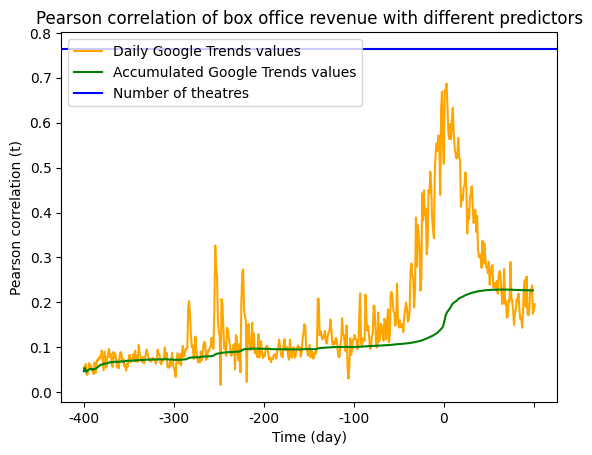

In [169]:
corr_matrix2['First_weekend_revenue_USD'][:-3].plot(label='Daily Google Trends values', color = 'orange')
corr_matrix['First_weekend_revenue_USD'][:-3].plot(label='Accumulated Google Trends values', color = 'green')
plt.axhline(y=corr_matrix['Number_of theaters']['First_weekend_revenue_USD'], color='blue', linestyle='-', label='Number of theatres')
plt.xlabel('Time (day)')
plt.ylabel('Pearson correlation (t)')
plt.title('Pearson correlation of box office revenue with different predictors')

plt.legend()
plt.savefig('Korrelation.png')

plt.show()

In [149]:
df = pd.read_csv('all_movies.csv')

### Calculate R² values

In [201]:
def r2_crossval(data, option, col, acc= False):
    data.sample(frac = 1)
    y = data[[col]]

# Initialize lists to store R-squared values and selected variable sets
    r2_values = []
    vars = range(-30,11)
# Loop through different numbers of variables
    for day in vars:
        X_subset = pd.DataFrame()
        if option in ('g', 'g&t'):
            X_subset['google']= data[str(day)]

        if option in ('t', 'g&t'):
            X_subset['Number_of theaters']= data['Number_of theaters']
        if acc == True:
            X_subset['Number_of theaters'] = acc_df[[str(day)]]
    
    # Create a linear regression model
        model = LinearRegression()
    
    # Perform cross-validation and calculate R-squared
        scores = cross_val_score(model, X_subset, y, cv=10, scoring='r2')
        r2 = np.mean(scores)
    
    # Append R-squared value and variable set to lists
        r2_values.append(r2)
    return r2_values

In [202]:
only_theatres = r2_crossval(df, 't', 'First_weekend_revenue_USD', False)
only_google_acc = r2_crossval(acc_df, 'g', 'First_weekend_revenue_USD', False)
both_acc = r2_crossval(acc_df, 'g&t', 'First_weekend_revenue_USD', False)
only_google = r2_crossval(df, 'g', 'First_weekend_revenue_USD', False)
both = r2_crossval(df, 'g&t', 'First_weekend_revenue_USD', False)

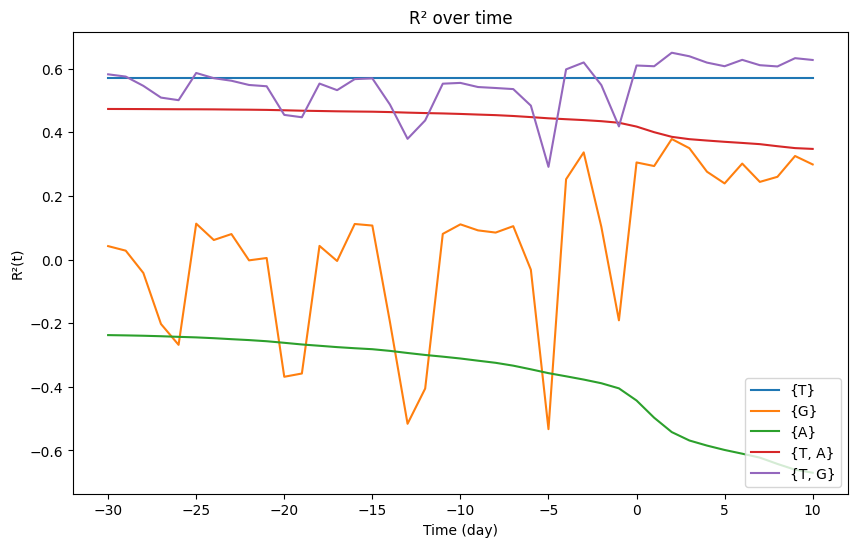

In [203]:
# Plot R-squared values
plt.figure(figsize=(10, 6))
plt.plot(range(-30,11), only_theatres, linestyle='-', label = '{T}')
plt.plot(range(-30,11), only_google, linestyle='-', label = '{G}')
plt.plot(range(-30,11), only_google_acc, linestyle='-', label = '{A}')
plt.plot(range(-30,11), both_acc, linestyle='-', label = '{T, A}')
plt.plot(range(-30,11), both, linestyle='-', label = '{T, G}')
plt.xlabel('Time (day)')
plt.ylabel('R²(t)')
plt.title('R² over time')

# Show legend
plt.legend(loc='lower right')
plt.savefig('r2.png')
# Show the plot
plt.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_18368\300320985.py:39: RuntimeWarning: invalid value encountered in log10
  plt.scatter(np.log10(pred3), np.log10(test['First_weekend_revenue_USD']), marker = 's', color = 'blue', alpha = 0.3, label = 'Number of theatres model')


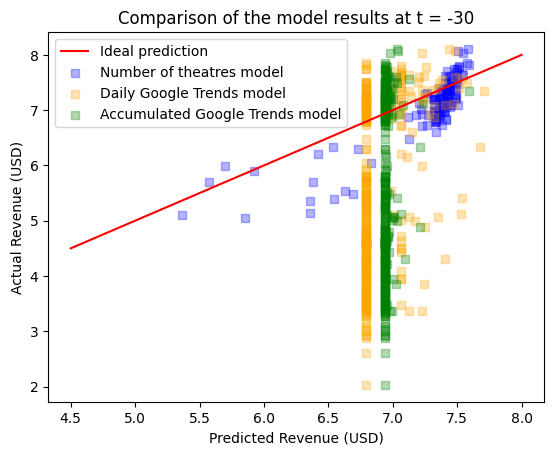

In [177]:
# Contemporary Google Trend
y = df[['First_weekend_revenue_USD']]
X = pd.DataFrame()
X['google']= df['-30']
reg = LinearRegression().fit(X, y)
pred = reg.predict(X)

# Benchmark model: only number of theaters
X = pd.DataFrame()
X['Number_of theaters']= df['Number_of theaters']
reg = LinearRegression().fit(X, y)
pred3 = reg.predict(X) 

# Accumulated Google Trend
X = pd.DataFrame()
X['google']= acc_df['-30']
reg = LinearRegression().fit(X, y)
pred4 = reg.predict(X)

min_value = min(min(pred), min(df['First_weekend_revenue_USD']))
max_value = max(max(pred), max(df['First_weekend_revenue_USD']))

# Line of ideal prediction
plt.plot([4.5, 8], [4.5, 8], color='red', label = 'Ideal prediction')

plt.xlabel('Predicted Revenue (USD)')
plt.ylabel('Actual Revenue (USD)')
plt.title('Comparison of the model results at t = -30')
plt.scatter(np.log10(pred3), np.log10(df['First_weekend_revenue_USD']), marker = 's', color = 'blue', alpha = 0.3, label = 'Number of theatres model')
plt.scatter(np.log10(pred), np.log10(df['First_weekend_revenue_USD']), marker = 's', color = 'orange', alpha = 0.3, label = 'Daily Google Trends model')
plt.scatter(np.log10(pred4), np.log10(df['First_weekend_revenue_USD']), marker = 's', color = 'green', alpha = 0.3, label = 'Accumulated Google Trends model')
plt.legend()
plt.savefig('model_preds')

In [70]:
# maximum R² values
print(max(only_theatres))
print(max(only_google))
print(max(both))

0.56965374624938
0.37992831104258773
0.6506208997423734


### Create histograms

In [15]:
test2 = df.drop(['Unnamed: 0', 'Title', 'First_weekend_revenue_USD', 'Number_of theaters', 'log_revenue'], axis = 1)

In [16]:
column_names_list = []
for index, row in test2.iterrows():
    for col, value in row.items():
        if isinstance(value, (int, float)) and value > 0:
            column_names_list.append(col)
            break  # Stop checking the remaining columns once a match is found

print(column_names_list)

['-72', '-278', '-208', '0', '-309', '-400', '-335', '-188', '-90', '-282', '-400', '-209', '-1', '-391', '-400', '-30', '-327', '-82', '-124', '-400', '-400', '-326', '57', '-276', '-145', '-400', '0', '-241', '1', '0', '-76', '-113', '-167', '-400', '-64', '-7', '-147', '-309', '-35', '-101', '-196', '-113', '-28', '29', '-139', '-400', '-218', '-109', '-399', '-129', '-400', '-227', '-122', '-2', '-294', '-223', '-180', '-166', '-400', '-341', '-56', '-180', '-70', '-379', '-26', '-400', '-1', '-86', '-112', '-40', '-12', '-188', '-400', '-75', '-178', '-26', '-400', '-81', '-216', '-282', '-180', '-400', '-400', '-102', '-355', '1', '-330', '-377', '-369', '-392', '-400', '-75', '-73', '-22', '-71', '-2', '-380', '-16', '-195', '-3', '-97', '-400', '-143', '-165', '-376', '-390', '-400', '-400', '-276', '-7', '-40', '-132', '-341', '-180', '-400', '-400', '-140', '-52', '-382', '-317', '-246', '-329', '-68', '-105', '-400', '-400', '18', '-208', '-51', '-91', '-68', '-397', '-138',

In [17]:
first_non_zero = [int(x) for x in column_names_list]

In [19]:
sum_per_row = test2[test2.columns].sum(axis=1)

test2['sum'] = sum_per_row

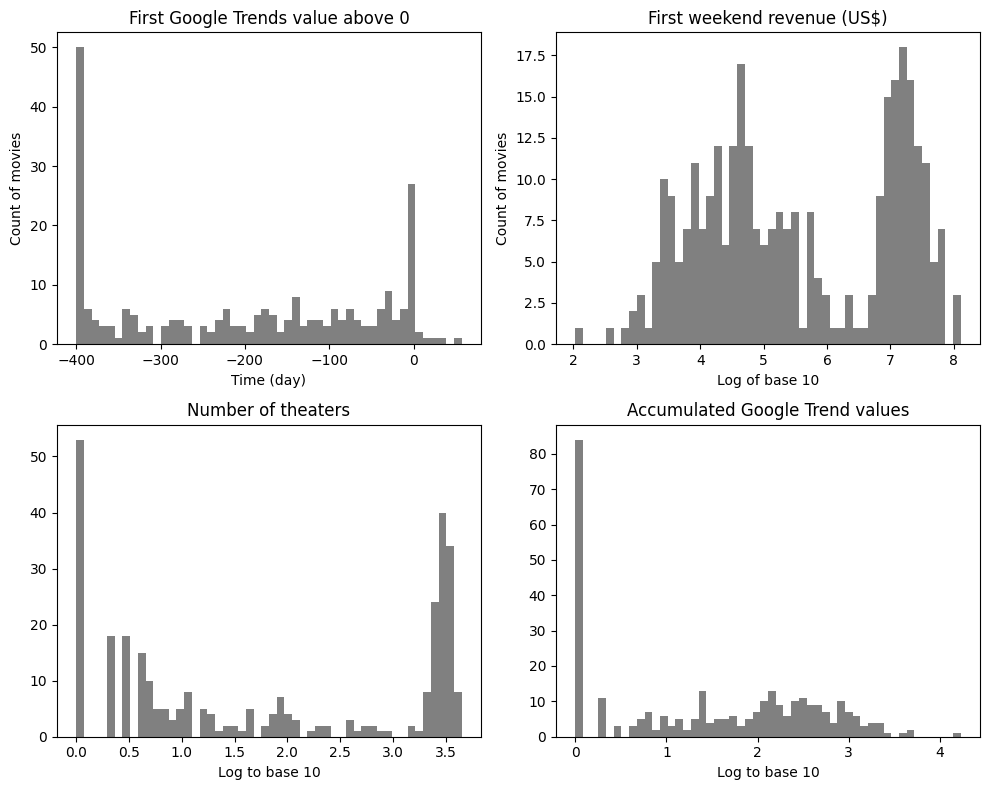

In [204]:
plt.figure(figsize=(10, 8)) 

plt.subplot(2, 2, 1)
plt.hist(first_non_zero, color = 'grey', bins = 50)
plt.title('First Google Trends value above 0')
plt.xlabel('Time (day)')
plt.ylabel('Count of movies')

plt.subplot(2, 2, 2)
plt.hist(np.log10(test['First_weekend_revenue_USD']), color = 'grey', bins = 50)
plt.title('First weekend revenue (US$)')
plt.xlabel('Log of base 10')
plt.ylabel('Count of movies')

plt.subplot(2, 2, 3)
plt.hist(np.log10(test['Number_of theaters']), color = 'grey', bins = 50)
plt.title('Number of theaters')
plt.xlabel('Log to base 10')

plt.subplot(2, 2, 4)
plt.hist(np.log10(test2['sum'].replace(0, 1)), color = 'grey', bins = 50)
plt.title('Accumulated Google Trend values')
plt.xlabel('Log to base 10')

plt.subplots_adjust(hspace=0.3)
plt.savefig('histograms.png')

plt.tight_layout()
